In [5]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [1]:
!pip install spanda

  Preparing metadata (setup.py) ... done
  Created wheel for brukeropusreader: filename=brukeropusreader-1.3.4-py3-none-any.whl size=5311 sha256=9ec8b50d924964e0773bb428c4842c14a4299749e9470e5c8e5a2152cdcf0c92
  Stored in directory: /root/.cache/pip/wheels/6a/0d/86/91cddedf53ade4d06446f0efb197520a25ccc18b6725c65378
Successfully built brukeropusreader


In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from tqdm import tqdm

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, DerivTfm,
                                    AnalytesTfm, SNVTfm, RandWAvgTfm, NormalizeTfm, LogTfm)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

analyte_name = 725

In [6]:
# Only samples with spectra
path = Path('/root/kssl-mirs-v2'); path.ls()

(#46305) [Path('/root/kssl-mirs-v2/174608'),Path('/root/kssl-mirs-v2/174916'),Path('/root/kssl-mirs-v2/19897'),Path('/root/kssl-mirs-v2/68409'),Path('/root/kssl-mirs-v2/86746'),Path('/root/kssl-mirs-v2/172147'),Path('/root/kssl-mirs-v2/199430'),Path('/root/kssl-mirs-v2/180551'),Path('/root/kssl-mirs-v2/25251'),Path('/root/kssl-mirs-v2/176480')...]

In [7]:
# keep only when spectra in folder
paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|██████████| 46305/46305 [00:01<00:00, 41168.86it/s]

n samples: 46251


In [8]:
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [9]:
# Only strictly positive measurements
paths = [p for p in paths if AnalytesTfm(analytes=[analyte_name])(get_target(p)) != 0] 
print(f'n samples: {len(paths)}')

n samples: 44565


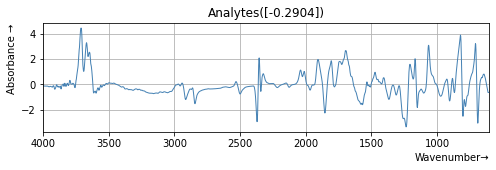

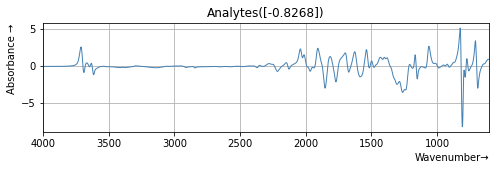

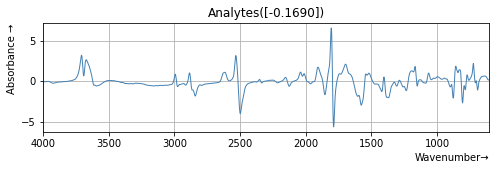

In [10]:
n_smp = None # None for all

get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte_name])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), DerivTfm(), SNVTfm(),
                              LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=3)
dls.show_batch()

In [11]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score()).to_fp16()

SuggestedLRs(valley=0.009120108559727669)

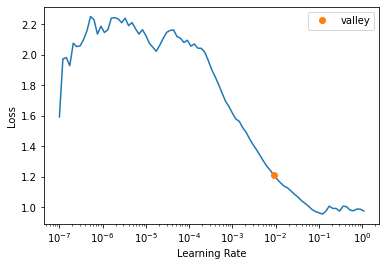

In [12]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-2)

epoch,train_loss,valid_loss,r2_score,time
0,0.118147,0.096815,0.580741,05:02
1,0.099177,0.094504,0.590746,05:07
2,0.098364,0.096574,0.581782,05:04
3,0.085903,0.092338,0.600127,05:01
4,0.092930,0.100406,0.565187,05:03
5,0.089062,0.091285,0.604688,05:16
6,0.098136,0.085371,0.630299,05:23
7,0.082076,0.095704,0.585549,05:14
8,0.083284,0.114712,0.503238,05:07
9,0.085590,0.076164,0.670170,05:07


In [ ]:
learn.save('xresnet18-kex-mirs-sg-kssl-20-epochs-lr-1e3-r2-xxx-290323')